In [ ]:

!pip install ultralytics
!pip install yolov5

import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import numpy as np
import logging
from pathlib import Path
from tqdm.notebook import tqdm
import random
import shutil
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from typing import List, Tuple, Dict
from google.colab import drive
import torch.nn.functional as F
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import torch.optim as optim
from collections import defaultdict
import time
from sklearn.manifold import TSNE


from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [ ]:
drive_zip_path = "/content/drive/My Drive/Colab_Backup/celeba_final_train.zip"

local_zip_path = "/content/dataset_clean.zip"
clean_data_dir = "/content/dataset_clean"

print(f"\nCopie de {drive_zip_path} vers {local_zip_path}...")
!cp "{drive_zip_path}" "{local_zip_path}"
print("Copie terminée.")

print(f"Décompression de {local_zip_path} vers {clean_data_dir}...")
os.makedirs(clean_data_dir, exist_ok=True)
!unzip -q "{local_zip_path}" -d "{clean_data_dir}"
print("Décompression terminée.")


Copie de /content/drive/My Drive/Colab_Backup/celeba_final_train.zip vers /content/dataset_clean.zip...
Copie terminée.
Décompression de /content/dataset_clean.zip vers /content/dataset_clean...
Décompression terminée.
✓ Vérification réussie : 10177 classes trouvées dans /content/dataset_clean

--- ENVIRONNEMENT PRÊT ---


In [ ]:
DRIVE_PATH_RAW_SOURCE = "/content/drive/My Drive/Colab_Backup/classe"
DRIVE_SOURCE_PATH = "/content/drive/My Drive/Colab_Backup/query_photo"

LOCAL_PATH_RAW = "/content/classe_raw"
LOCAL_DESTINATION_PATH = "/content/query_test_images"

shutil.copytree(DRIVE_PATH_RAW_SOURCE, LOCAL_PATH_RAW)
shutil.copytree(DRIVE_SOURCE_PATH, LOCAL_DESTINATION_PATH)



'/content/query_test_images'

In [ ]:
# =============================================================
#                           PROTO-NET (CNN)
# =============================================================


def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==================== 1. Encoder ====================

class EnhancedProtoNetEncoder(nn.Module):
    """Encodeur avec plus de capacité et GroupNorm pour la stabilité"""
    def __init__(self, input_dim=3, hidden_dim=64, feature_dim=128):
        super(EnhancedProtoNetEncoder, self).__init__()

        #constuction du modèle CNN à 4 couches
        self.network = nn.Sequential(
            # Bloc 1
            nn.Conv2d(input_dim, hidden_dim, 3, padding=1), #hidden => nb filtre qu'on va utiliser
            nn.GroupNorm(8, hidden_dim), # normalisation des features maps
            nn.ReLU(inplace=True),  #fonction d'activation pour la normalisation
            nn.MaxPool2d(2),  #reduction d'image

            # Bloc 2
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1),
            nn.GroupNorm(16, hidden_dim * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Bloc 3
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1),
            nn.GroupNorm(32, hidden_dim * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Bloc 4
            nn.Conv2d(hidden_dim * 4, feature_dim, 3, padding=1),
            nn.GroupNorm(32, feature_dim),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.network(x)
        x = x.view(x.size(0), -1)
        return x



# ==================== 2. DATALOADER  ====================

class SimpleFaceDataset:
    def __init__(self, root_dir, split='train', train_ratio=0.8,
                 max_classes=1000, image_size=128):
        self.root_dir = Path(root_dir)
        self.image_size = image_size
        self.yolo_model = YOLO("yolov8n-face.pt")

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        all_dirs = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])
        random.seed(42)
        random.shuffle(all_dirs)

        num_total = len(all_dirs)
        num_train = int(num_total * train_ratio)

        if split == 'train':
            self.selected_dirs = all_dirs[:num_train]
        else:  # test
            self.selected_dirs = all_dirs[num_train:]

        self.data = self._load_dataset()
        self.classes = list(self.data.keys())
        print(f"✓ Split {split.upper()}: {len(self.classes)} identités chargées")


    def _load_dataset(self):
        data = {}
        for class_dir in self.selected_dirs:
            images = []
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                images.extend(class_dir.glob(ext))

            if len(images) >= 15:
                data[class_dir.name] = [str(img) for img in images]
        return data



    def detect_face_with_yolo(self, pil_img):
        try:
            with torch.no_grad():
                results = self.yolo_model(pil_img, verbose=False)

            if results and len(results[0].boxes) > 0:
                box = results[0].boxes[0]
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                return (x1, y1, x2, y2)
        except Exception as e:
            print(f"⚠️ Erreur détection YOLO: {e}")

        return None


    def load_image(self, image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            bbox = self.detect_face_with_yolo(img)
            img = img.crop(bbox)
            return self.transform(img)

        except Exception as e:
            print(f"⚠️ Erreur chargement {image_path}: {e}")
            return torch.zeros(3, self.image_size, self.image_size)

    def sample_task(self, n_way, k_shot, q_query):
        """Échantillonne une tâche few-shot"""
        valid_classes = [cls for cls in self.classes if len(self.data[cls]) >= k_shot + q_query]

        if len(valid_classes) < n_way:
            n_way = len(valid_classes)

        selected_classes = random.sample(valid_classes, n_way)

        support_x, support_y, query_x, query_y = [], [], [], []

        for label, cls in enumerate(selected_classes):
            images = random.sample(self.data[cls], k_shot + q_query)

            # Support set
            for img_path in images[:k_shot]:
                support_x.append(self.load_image(img_path))
                support_y.append(label)

            # Query set
            for img_path in images[k_shot:k_shot + q_query]:
                query_x.append(self.load_image(img_path))
                query_y.append(label)

        return (torch.stack(support_x), torch.tensor(support_y, dtype=torch.long),
                torch.stack(query_x), torch.tensor(query_y, dtype=torch.long))

# ==================== 3. TRAINER (gestion de la pipeline d'apprentissage) ====================

class AdvancedProtoNetTrainer:
    def __init__(self, encoder,num_epochs, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.encoder = encoder.to(self.device)
        self.optimizer = optim.AdamW(encoder.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_epochs)
        self.criterion = nn.CrossEntropyLoss()

        self.train_losses = []
        self.train_accuracies = []
        self.learning_rates = []

    def compute_prototypes(self, support_x, support_y, n_way):
        support_features = self.encoder(support_x)
        if support_features.dim() == 1:
            support_features = support_features.unsqueeze(0)

        prototypes = []
        for c in range(n_way):
            mask = (support_y == c)
            if mask.sum() > 0:
                class_features = support_features[mask]
                prototype = class_features.mean(dim=0)
            else:
                prototype = torch.zeros_like(support_features[0])
            prototypes.append(prototype)

        return torch.stack(prototypes)

    def calculate_loss_acc(self, query_x, query_y, prototypes):
        query_features = self.encoder(query_x)

        n_query = query_features.shape[0]
        n_way = prototypes.shape[0]
        distances = (
            query_features.unsqueeze(1).expand(n_query, n_way, -1) -
            prototypes.unsqueeze(0).expand(n_query, n_way, -1)
        ).pow(2).sum(dim=2)

        logits = -distances

        loss = self.criterion(logits, query_y)
        predictions = torch.argmin(distances, dim=1)
        accuracy = (predictions == query_y).float().mean().item()

        return loss, accuracy

    # gestion des epoques d'apprentissage
    def train_epoch(self, dataset, n_way, k_shot, q_query, tasks_per_epoch):
        self.encoder.train()
        epoch_losses = []
        epoch_accuracies = []

        for _ in range(tasks_per_epoch):
            support_x, support_y, query_x, query_y = dataset.sample_task(n_way, k_shot, q_query)
            support_x, support_y = support_x.to(self.device), support_y.to(self.device)
            query_x, query_y = query_x.to(self.device), query_y.to(self.device)

            prototypes = self.compute_prototypes(support_x, support_y, n_way)
            loss, accuracy = self.calculate_loss_acc(query_x, query_y, prototypes)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), max_norm=1.0)
            self.optimizer.step()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(accuracy)

        self.scheduler.step()
        current_lr = self.optimizer.param_groups[0]['lr']
        self.learning_rates.append(current_lr)

        avg_loss = np.mean(epoch_losses)
        avg_acc = np.mean(epoch_accuracies)
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(avg_acc)

        return avg_loss, avg_acc, current_lr


    def evaluate(self, dataset, n_way, k_shot, q_query, n_episodes=100):
        """⭐ NOUVELLE FONCTION: Évaluation sur dataset de test"""
        self.encoder.eval()
        accuracies = []

        print(f"\n🧪 Évaluation sur {n_episodes} épisodes ({n_way}-way {k_shot}-shot)...")

        with torch.no_grad():
            for episode in range(n_episodes):
                support_x, support_y, query_x, query_y = dataset.sample_task(
                    n_way, k_shot, q_query
                )
                support_x = support_x.to(self.device)
                support_y = support_y.to(self.device)
                query_x = query_x.to(self.device)
                query_y = query_y.to(self.device)

                prototypes = self.compute_prototypes(support_x, support_y, n_way)
                _, accuracy = self.calculate_loss_acc(query_x, query_y, prototypes)
                accuracies.append(accuracy)

                if (episode + 1) % 20 == 0:
                    print(f"  Episode {episode+1}/{n_episodes}: {np.mean(accuracies[-20:]):.3f}")

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        conf_interval = 1.96 * std_acc / np.sqrt(n_episodes)  # 95% CI

        print(f"\n📊 Résultat: {mean_acc:.4f} ± {conf_interval:.4f}")
        return mean_acc, conf_interval ,accuracies


# ==================== 4. FONCTIONS D'ORCHESTRATION ====================

def run_advanced_protonet(dataset_path, n_way=5, k_shot=1, q_query=5, num_epochs=100, tasks_per_epoch=50):

    print("="*70)
    print("🚀 PROTO-NET  )")
    print("="*70)
    print(f"Configuration: {n_way}-way {k_shot}-shot ")
    print(f"Query: {q_query} images | Tâches/epoch: {tasks_per_epoch}")
    print("="*70)

    set_seed(42)  # Pour reproduire les résultats
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Device: {device}")

    # 1. Dataset
    print("📂 Chargement du dataset...")
    train_dataset = SimpleFaceDataset(dataset_path, split='train')
    test_dataset = SimpleFaceDataset(dataset_path, split='test')  # Tout le test
    print()

    # 2. Modèle amélioré
    print("🏗️  Création du modèle ...")
    encoder = EnhancedProtoNetEncoder(input_dim=3, hidden_dim=64, feature_dim=128)
    print(f"✓ Modèle: {sum(p.numel() for p in encoder.parameters()):,} paramètres")


    # 3. Trainer
    trainer = AdvancedProtoNetTrainer(encoder, num_epochs, device=device)
    print(f"✓ Trainer initialisé")
    print()

    # 4. Entraînement
    print("🚀 Début de l'entraînement ...")
    print("-"*70)

    start_time = time.time()
    best_acc = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        avg_loss, avg_acc, current_lr = trainer.train_epoch(
            train_dataset, n_way, k_shot, q_query, tasks_per_epoch
        )

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {avg_loss:.4f} | "
                  f"Acc: {avg_acc*100:5.1f}% | LR: {current_lr:.2e}")

        if avg_acc > best_acc:
            best_acc = avg_acc
            best_epoch = epoch + 1


    total_time = time.time() - start_time

    # 5. Évaluation finale sur test
    print("\n" + "="*70)
    print("🎯 ÉVALUATION FINALE SUR TEST SET")
    print("="*70)


    mean_acc, conf, accuracies = trainer.evaluate(test_dataset, 20, 1, q_query, n_episodes=50)
    print(f"✅ 20-way 1-shot: {mean_acc*100:.2f}% ± {conf*100:.2f}%")

    plot_advanced_results(trainer)
    return trainer, train_dataset, test_dataset , accuracies


def plot_advanced_results(trainer):
    """Visualisation détaillée des résultats"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    ax1.plot(trainer.train_losses)
    ax1.set_title('Evolution de la Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot([acc * 100 for acc in trainer.train_accuracies], 'orange')
    ax2.axhline(y=5, color='red', linestyle='--', label='Aléatoire (5%)')
    ax2.set_title('Accuracy d\'entraînement')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning rate
    ax3.plot(trainer.learning_rates, 'green')
    ax3.set_title('Evolution du Learning Rate')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # Moving average
    if len(trainer.train_accuracies) > 10:
        window = 10
        moving_avg = np.convolve(trainer.train_accuracies, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(trainer.train_accuracies)), [x * 100 for x in moving_avg], 'purple')
        ax4.set_title(f'Accuracy Moyenne (fenêtre {window})')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy (%)')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


🎯 PROTO-NET  - LANCEMENT
🚀 PROTO-NET  )
Configuration: 20-way 1-shot 
Query: 10 images | Tâches/epoch: 50
📱 Device: cuda
📂 Chargement du dataset...
✓ Split TRAIN: 5949 identités chargées
✓ Split TEST: 1468 identités chargées

🏗️  Création du modèle ...
✓ Modèle: 667,008 paramètres
✓ Trainer initialisé

🚀 Début de l'entraînement ...
----------------------------------------------------------------------
Epoch   1/50 | Loss: 2.9579 | Acc:  11.5% | LR: 9.99e-04
Epoch   5/50 | Loss: 2.6421 | Acc:  21.0% | LR: 9.76e-04
Epoch  10/50 | Loss: 2.3170 | Acc:  28.5% | LR: 9.05e-04
Epoch  15/50 | Loss: 2.0957 | Acc:  36.1% | LR: 7.94e-04
Epoch  20/50 | Loss: 1.8899 | Acc:  41.6% | LR: 6.55e-04
Epoch  25/50 | Loss: 1.7788 | Acc:  45.1% | LR: 5.00e-04
Epoch  30/50 | Loss: 1.6856 | Acc:  48.0% | LR: 3.45e-04
Epoch  35/50 | Loss: 1.6031 | Acc:  49.6% | LR: 2.06e-04
Epoch  40/50 | Loss: 1.5502 | Acc:  51.9% | LR: 9.55e-05
Epoch  45/50 | Loss: 1.5231 | Acc:  51.9% | LR: 2.45e-05
Epoch  50/50 | Loss: 1.51

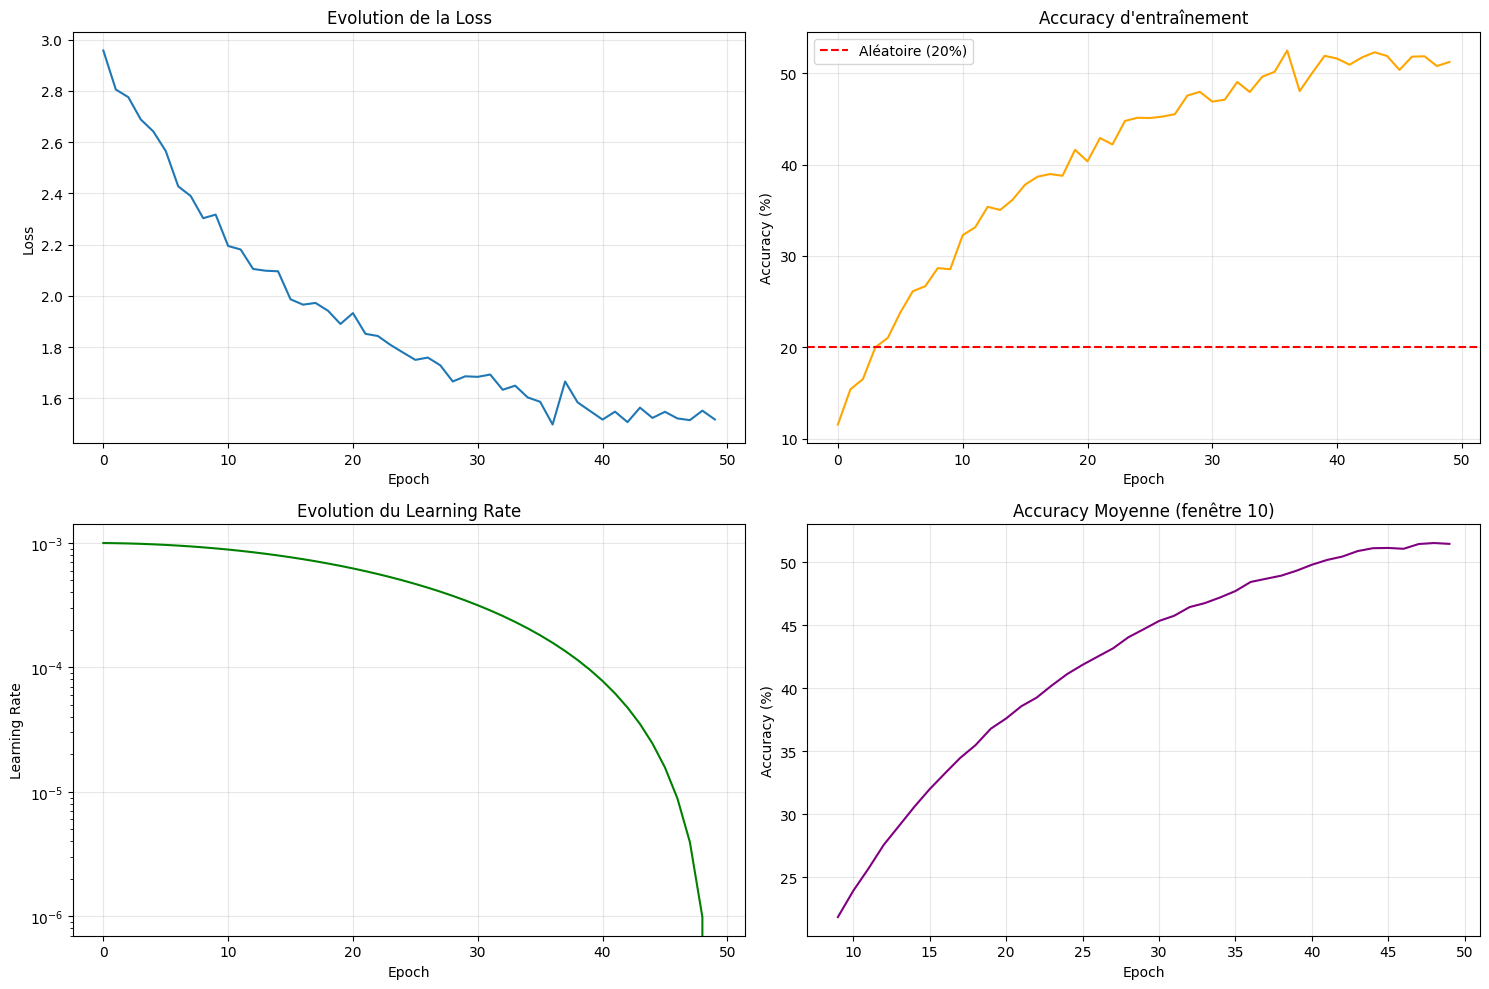


💾 Sauvegarde du modèle...
✓ Modèle (encodeur) sauvegardé dans votre Drive à : /content/drive/My Drive/Colab_Backup/protonet_v1_CNN.pth

--- ENTRAÎNEMENT TERMINÉ ---


In [ ]:
# ====================  ENTRAÎNEMENT DE PROTO-NET ====================

print("🎯 PROTO-NET  - LANCEMENT")

# Configuration
N_WAY = 20
K_SHOT = 1
Q_QUERY = 10
EPOCHS = 50
TASKS_PER_EPOCH = 50

# Entraînement
trainer, train_dataset , test_dataset , accuracies = run_advanced_protonet(
    dataset_path='/content/dataset_clean',
    n_way=N_WAY,
    k_shot=K_SHOT,
    q_query=Q_QUERY,
    num_epochs=EPOCHS,
    tasks_per_epoch=TASKS_PER_EPOCH,
)

# Sauvegarde du modèle entraîné
print("\n💾 Sauvegarde du modèle...")
try:
    save_path = "/content/drive/My Drive/Colab_Backup/protonet_v1_CNN.pth"
    torch.save(trainer.encoder.state_dict(), save_path)
    print(f"✓ Modèle (encodeur) sauvegardé dans votre Drive à : {save_path}")
except Exception as e:
    print(f"✗ ERREUR de sauvegarde. 'trainer' est-il en mémoire ? Erreur: {e}")

print("\n--- ENTRAÎNEMENT TERMINÉ ---")

In [ ]:
%matplotlib inline



# ====================  SYSTÈME DE RECONNAISSANCE ====================
class FaceRecognitionSystem:
    def __init__(self, encoder_path, yolo_model_path, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Initialisation sur : {self.device}")

        # Chargement YOLO
        print("   [1/3] Chargement de YOLO...")
        self.yolo = YOLO(yolo_model_path)

        # Chargement ProtoNet
        print("   [2/3] Chargement de ProtoNet (ResNet18)...")
        self.encoder = EnhancedProtoNetEncoder(feature_dim=128).to(self.device)

        try:
            state_dict = torch.load(encoder_path, map_location=self.device)
            self.encoder.load_state_dict(state_dict)
            self.encoder.eval()
            print("   ✅ Poids chargés avec succès !")
        except Exception as e:
            print(f"❌ ERREUR CRITIQUE : {e}")
            raise e

        self.database = {}
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print("   [3/3] Système prêt.")

    def _get_embedding(self, img_crop):
        img_tensor = self.transform(img_crop).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.encoder(img_tensor)
        return embedding

    def enroll_users(self, folder_path):
        print(f"\n📂 Démarrage de l'Enrôlement depuis : {folder_path}")
        folder = Path(folder_path)
        extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        image_files = [f for f in folder.iterdir() if f.suffix.lower() in extensions]
        image_files.sort()

        print(f"   ℹ️  {len(image_files)} images trouvées.")
        success_count = 0

        for img_path in image_files:
            person_name = img_path.stem
            try:
                results = self.yolo(str(img_path), verbose=False)
                if len(results[0].boxes) == 0:
                    print(f"   ⚠️  {person_name}: Pas de visage détecté")
                    continue

                boxes = results[0].boxes
                areas = [(b.xyxy[0][2]-b.xyxy[0][0])*(b.xyxy[0][3]-b.xyxy[0][1]) for b in boxes]
                best_box = boxes[areas.index(max(areas))]

                img_pil = Image.open(img_path).convert('RGB')
                x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())
                margin = 10
                x1, y1, x2, y2 = max(0, x1-margin), max(0, y1-margin), min(img_pil.width, x2+margin), min(img_pil.height, y2+margin)

                face_crop = img_pil.crop((x1, y1, x2, y2))

                vector = self._get_embedding(face_crop)
                self.database[person_name] = vector
                success_count += 1
                print(f"   ✅ {person_name:15s} : OK")

            except Exception as e:
                print(f"   ❌ Erreur sur {person_name}: {e}")

        print(f"\n🎉 Base terminée : {success_count} enregistrés.")


    def recognize_image(self, test_image_path, threshold=1.0, output_path="resultat.jpg"):
        print(f"\n📸 DIAGNOSTIC APPROFONDI sur : {test_image_path}")

        results = self.yolo.predict(test_image_path)
        if len(results[0].boxes) == 0:
            print("   ⚠️ Aucun visage trouvé.")
            return

        img_cv = cv2.imread(test_image_path)
        img_pil = Image.open(test_image_path).convert('RGB')

        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            margin = 10
            cx1, cy1, cx2, cy2 = max(0, x1-margin), max(0, y1-margin), min(img_pil.width, x2+margin), min(img_pil.height, y2+margin)
            face_crop = img_pil.crop((cx1, cy1, cx2, cy2))


            query_vec = self._get_embedding(face_crop)

            distances = []

            for name, ref_vec in self.database.items():
                dist = torch.dist(query_vec, ref_vec).item()
                distances.append((name, dist))

            distances.sort(key=lambda x: x[1])

            print("\n   --- 🏆 CLASSEMENT DES RESSEMBLANCES ---")
            best_name, best_dist = distances[0]

            for i, (name, dist) in enumerate(distances[:5]):
                marker = "👈 (Faux Positif?)" if i == 0 else ""
                print(f"   #{i+1} : {name:15s} | Distance: {dist:.4f} {marker}")

            final_name = best_name if best_dist < threshold else "Inconnu"

            color = (0, 255, 0) if final_name == best_name else (0, 0, 255)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv, f"{final_name} ({best_dist:.2f})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

        cv2.imwrite(output_path, img_cv)
        print(f"\n✅ Image sauvegardée : {output_path}")

# ==================== EXÉCUTION ====================

PROTONET_MODEL = "/content/drive/My Drive/Colab_Backup/protonet_v1_CNN.pth"
YOLO_MODEL = "yolov8n-face.pt"
FOLDER_CLASSE_RAW = "/content/classe_raw"
IMAGE_A_TESTER = "/content/query_test_images/query_photo/222.jpeg"

if __name__ == "__main__":
    try:
        system = FaceRecognitionSystem(PROTONET_MODEL, YOLO_MODEL)
        system.enroll_users(FOLDER_CLASSE_RAW)
        if len(system.database) > 0:
            system.recognize_image(IMAGE_A_TESTER, threshold=3, output_path="resultat_final.jpg")
        else:
            print("❌ Base vide.")
    except Exception as e:
        print(f"❌ Erreur : {e}")

📱 Initialisation sur : cpu
   [1/3] Chargement de YOLO...
   [2/3] Chargement de ProtoNet (ResNet18)...
   ✅ Poids chargés avec succès !
   [3/3] Système prêt.

📂 Démarrage de l'Enrôlement depuis : /content/classe_raw
   ℹ️  21 images trouvées.
   ✅ akil            : OK
   ✅ anthony_ca      : OK
   ✅ anthony_s       : OK
   ✅ anziza          : OK
   ✅ ayoub           : OK
   ✅ cedric          : OK
   ✅ chamss          : OK
   ✅ clement         : OK
   ✅ elhadji         : OK
   ✅ enzo_m          : OK
   ✅ enzo_n          : OK
   ✅ louison         : OK
   ✅ lounes          : OK
   ✅ maximiliano     : OK
   ✅ melanie         : OK
   ✅ moustapha       : OK
   ✅ omia            : OK
   ✅ ryan            : OK
   ✅ samy            : OK
   ✅ sosth           : OK
   ✅ yanis           : OK

🎉 Base terminée : 21 enregistrés.

📸 DIAGNOSTIC APPROFONDI sur : /content/query_test_images/query_photo/222.jpeg

   --- 🏆 CLASSEMENT DES RESSEMBLANCES ---
   #1 : enzo_m          | Distance: 1.8071 👈 (Faux P